In [6]:
import pandas as pd

# 讀取上傳的報酬資料
file_path = "combined_sorted_stock_returns.csv"
df_returns = pd.read_csv(file_path)

# 檢查資料格式
df_returns.head()

,代號,名稱,年月日,日報酬率 %
0,1101,台泥,2015-01-05,-0.9217
1,1101,台泥,2015-01-06,-1.7442
2,1101,台泥,2015-01-07,-0.3550
3,1101,台泥,2015-01-08,0.3563
4,1101,台泥,2015-01-09,-1.0651


In [7]:
# 將日報酬率轉為 float 並除以 100（轉為小數）
df_returns["日報酬率 %"] = pd.to_numeric(df_returns["日報酬率 %"], errors="coerce") / 100

# 將日期轉換為 datetime 格式
df_returns["年月日"] = pd.to_datetime(df_returns["年月日"])

# 將資料 pivot 成 [日期 x 股票代碼] 的報酬矩陣
pivot_df = df_returns.pivot(index="年月日", columns="代號", values="日報酬率 %")

# 檢查轉換後的格式
pivot_df.head()

代號,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9945,9946,9955,9958,910322,910861,911608,911622,911868,912000
年月日,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.009217,-0.019231,0.007067,0.007752,0.009709,0.011236,-0.026471,0.000000,-0.004202,-0.005445,...,-0.007937,-0.002299,0.002725,-0.018265,-0.005682,0.042403,0.015306,0.0,0.000000,0.013378
2015-01-06,-0.017442,-0.016993,-0.007018,-0.009615,-0.014423,-0.007407,-0.003021,-0.006000,0.004219,-0.016423,...,-0.021000,-0.027650,0.008152,-0.013953,0.000000,0.016949,0.000000,0.0,-0.020833,0.000000
2015-01-07,-0.003550,0.010638,0.003534,0.003883,0.004878,0.000000,-0.009091,-0.010060,-0.002101,0.001855,...,0.001021,-0.004739,0.005391,-0.009434,0.014286,0.006667,0.013400,0.0,0.059574,0.019802
2015-01-08,0.003563,0.011842,0.007042,0.001934,0.000000,0.000000,-0.003058,0.002033,-0.006316,0.007407,...,0.008163,-0.019048,-0.002681,-0.004762,0.023944,-0.013245,0.000000,0.0,-0.044177,0.000000
2015-01-09,-0.010651,0.000000,0.003497,0.001931,0.000000,0.014925,0.006135,0.004057,0.002119,0.005515,...,-0.002024,0.004854,0.000000,0.004785,-0.006878,-0.003356,0.008264,0.0,0.025210,-0.003236


In [8]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# pivot_df 已經處理好，格式為 [日期 × 股票] 報酬矩陣
# 切分訓練集與測試集（以2024年為界）
train_df = pivot_df[pivot_df.index < "2024-01-01"]
test_df = pivot_df[pivot_df.index >= "2024-01-01"]

# 對訓練集做 PCA 拆解
train_df_clean = train_df.fillna(0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df_clean)

n_components = 5
pca = PCA(n_components=n_components)
train_factors = pca.fit_transform(X_train_scaled)
pca_components = pca.components_

# 用測試集資料來計算預測報酬與殘差
test_df_clean = test_df.fillna(0)
X_test_scaled = scaler.transform(test_df_clean)  # 注意：scaler 用訓練集的
predicted_test_scaled = X_test_scaled @ pca_components.T @ pca_components
predicted_test = scaler.inverse_transform(predicted_test_scaled)

# 預測報酬與殘差
predicted_test_df = pd.DataFrame(predicted_test, index=test_df_clean.index, columns=test_df_clean.columns)
residual_df = test_df_clean - predicted_test_df

In [9]:
residual_df

代號,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9945,9946,9955,9958,910322,910861,911608,911622,911868,912000
年月日,,,,,,,,,,,,,,,,,,,,,
2024-01-02,-0.002165,-0.005219,-0.014056,-0.002767,-0.005313,-0.004713,-0.002146,-0.002210,0.023179,0.004334,...,0.039062,0.026203,-0.010156,-0.010696,-0.014358,-0.004958,-0.000474,-0.000311,-0.009894,-0.000105
2024-01-03,-0.003050,-0.001277,0.000528,-0.001123,0.002155,0.001404,-0.002529,0.005310,-0.010925,0.003287,...,-0.003619,0.001100,0.002266,0.025592,0.005584,-0.014058,0.002686,-0.003136,0.001109,0.006041
2024-01-04,-0.002611,0.009798,-0.000939,-0.014179,-0.000165,0.001408,0.010481,-0.001334,-0.009841,-0.010565,...,-0.004620,0.026024,-0.015271,0.010293,0.014121,-0.005663,-0.000710,-0.001750,-0.014495,-0.003931
2024-01-05,0.005589,-0.000096,-0.001497,0.007326,-0.004689,-0.002879,-0.005931,-0.001715,0.012731,-0.012400,...,-0.014244,-0.003754,0.009786,0.014314,0.002974,-0.001322,-0.003617,-0.000181,0.005719,-0.004679
2024-01-08,-0.003983,0.003281,-0.000410,-0.005332,0.004491,-0.004426,-0.002297,-0.001959,-0.006104,0.001525,...,-0.011768,-0.000483,-0.010365,0.000736,-0.018490,-0.028497,0.000602,0.002023,0.001229,-0.005193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-20,0.008603,0.017284,-0.000230,0.002711,0.000264,0.011895,0.027653,0.001242,0.013680,0.011887,...,0.001540,0.012862,-0.003876,-0.000569,0.006584,-0.007053,-0.003712,-0.000564,-0.000703,-0.004168
2025-05-21,-0.001185,-0.012318,0.008952,0.003314,-0.007531,-0.002142,0.001018,0.000009,-0.005761,-0.006036,...,0.002513,0.019950,0.011827,-0.008887,-0.004663,-0.017922,-0.032548,-0.001177,-0.004571,-0.001526
2025-05-22,-0.001735,-0.024767,-0.002937,0.001258,0.008230,-0.001046,0.007824,0.002726,-0.002101,0.006652,...,-0.013885,-0.003738,0.020781,0.008428,-0.009564,0.003499,-0.002880,-0.004446,-0.006094,-0.007517


In [10]:
import numpy as np
import pandas as pd

# 將 residual_df 與原始 test_df 對齊
residual_df = residual_df.dropna(how="all")
test_returns = test_df.loc[residual_df.index].fillna(0)

long_returns = []
short_returns = []

dates = residual_df.index
holding_period = 2

for i in range(len(dates) - holding_period):
    today = dates[i]
    future_dates = dates[i+1:i+1+holding_period]  # 隔日買進持有兩天

    residuals_today = residual_df.loc[today].dropna()
    if len(residuals_today) < 10:
        continue

    # 依殘差排序
    lower_q = residuals_today.quantile(0.2)
    upper_q = residuals_today.quantile(0.8)

    long_stocks = residuals_today[residuals_today <= lower_q].index
    short_stocks = residuals_today[residuals_today >= upper_q].index

    # 計算未來2日這些股票的平均報酬
    future_ret = test_returns.loc[future_dates]

    long_ret = future_ret[long_stocks].mean(axis=1).mean()
    short_ret = future_ret[short_stocks].mean(axis=1).mean()

    long_returns.append((today, long_ret))
    short_returns.append((today, short_ret))

# 整理報酬 DataFrame 與長期績效
long_df = pd.DataFrame(long_returns, columns=["Date", "Long_Return"]).set_index("Date")
short_df = pd.DataFrame(short_returns, columns=["Date", "Short_Return"]).set_index("Date")
ls_df = long_df.join(short_df)
ls_df["LongShort"] = ls_df["Long_Return"] - ls_df["Short_Return"]
ls_df["Cumulative"] = (1 + ls_df["LongShort"]).cumprod()

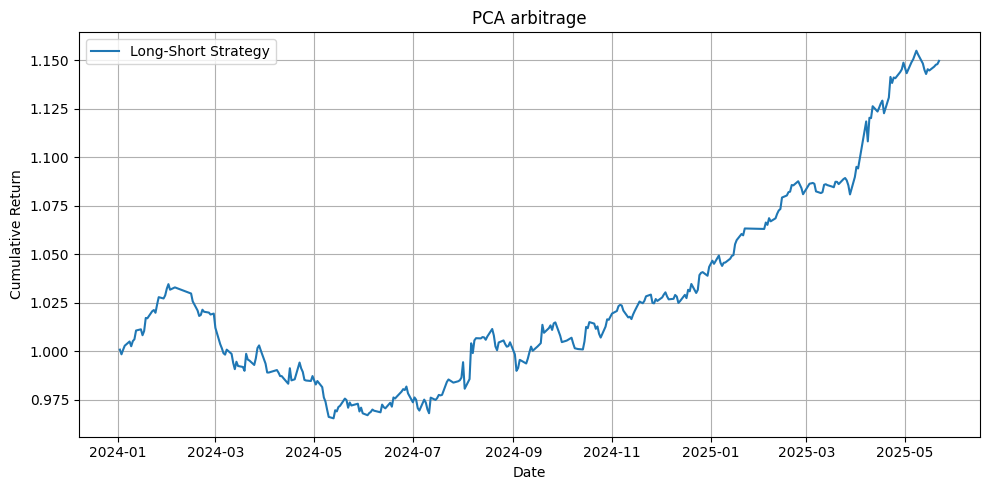

Sharpe Ratio: 1.86
Annualized Return: 11.17%


In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(ls_df.index, ls_df["Cumulative"], label="Long-Short Strategy")
plt.title("PCA arbitrage")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

sharpe_ratio = ls_df["LongShort"].mean() / ls_df["LongShort"].std() * np.sqrt(252)
annual_return = (ls_df["Cumulative"].iloc[-1])**(252/len(ls_df)) - 1

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Return: {annual_return:.2%}")